In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import keras_tuner as kt
import seaborn as sns

In [202]:
# Load and preprocess data
df = pd.read_csv("Tesla.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [203]:
df['Volume'] = df['Volume'].astype(str).str.replace(',', '')
df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')

In [204]:
df = df.dropna()

In [205]:
# Add technical indicators
df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI_14'] = 100 - (100 / (1 + rs))

In [206]:
# Drop NaNs from indicators
df.dropna(inplace=True)


In [207]:
# Features
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'EMA_10', 'RSI_14']
data = df[features]

In [208]:
print("Summary Statistics:")
print(df[features].describe())

Summary Statistics:
             Open        High         Low       Close        Volume  \
count  238.000000  238.000000  238.000000  238.000000  2.380000e+02   
mean   279.171008  286.115630  271.832101  279.155126  9.696203e+07   
std     77.008209   78.717074   74.266854   76.456118  3.844158e+07   
min    171.120000  174.750000  167.410000  170.660000  3.716762e+07   
25%    223.562500  226.855000  217.290000  221.462500  6.805355e+07   
50%    253.165000  259.645000  246.195000  252.790000  8.712404e+07   
75%    341.622500  347.275000  333.912500  338.500000  1.153669e+08   
max    475.900000  488.540000  457.510000  479.860000  2.217073e+08   

           SMA_10      EMA_10      RSI_14  
count  238.000000  238.000000  238.000000  
mean   282.037197  282.073415   45.382899  
std     73.531595   72.433187   18.653337  
min    175.899000  177.869313    4.333644  
25%    228.712250  229.902339   31.356179  
50%    253.168500  254.914942   43.727572  
75%    336.033500  336.052157   

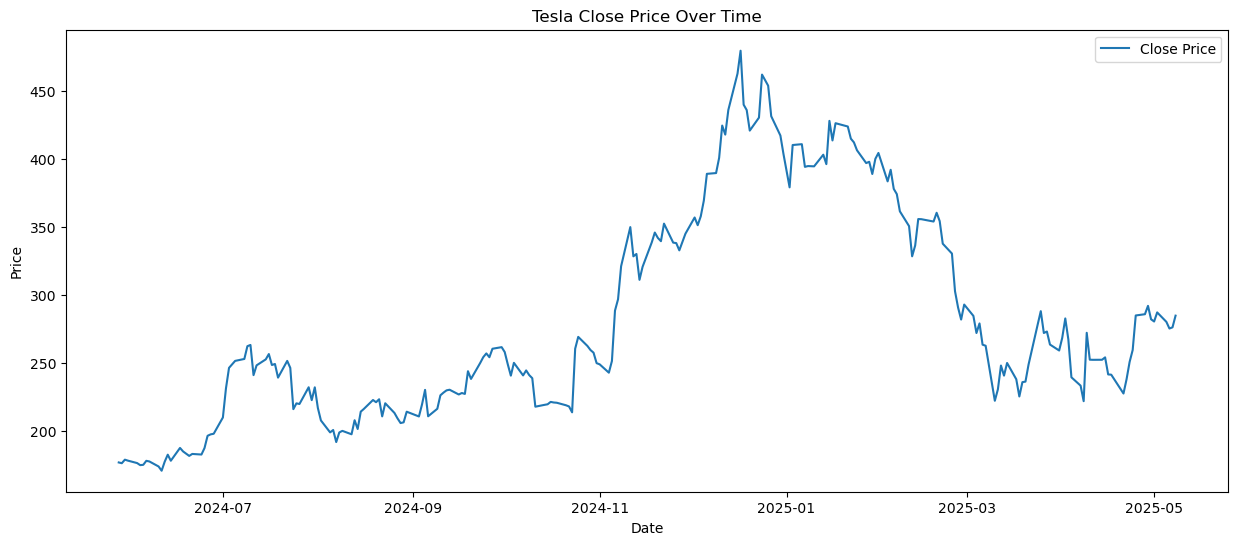

In [209]:
# Price trends
plt.figure(figsize=(15, 6))
plt.plot(df['Close'], label='Close Price')
plt.title('Tesla Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

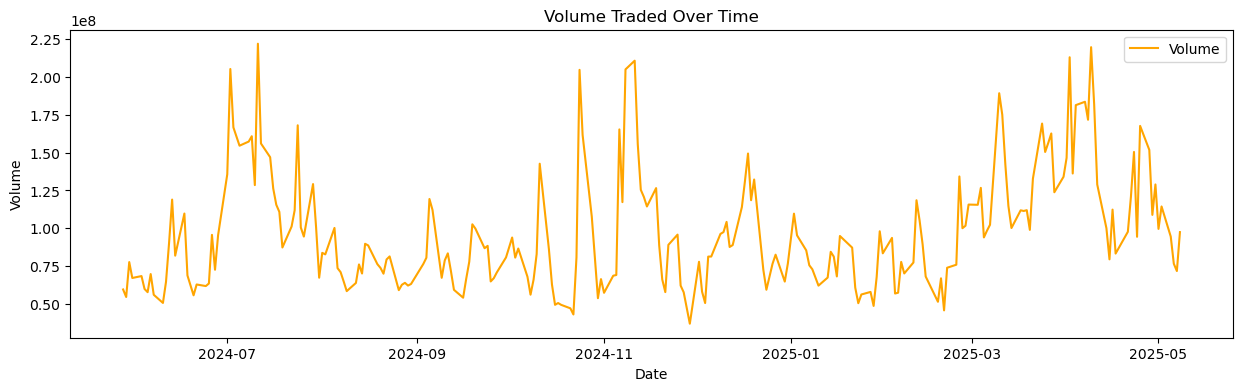

In [210]:
# Volume over time
plt.figure(figsize=(15, 4))
plt.plot(df['Volume'], color='orange', label='Volume')
plt.title('Volume Traded Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

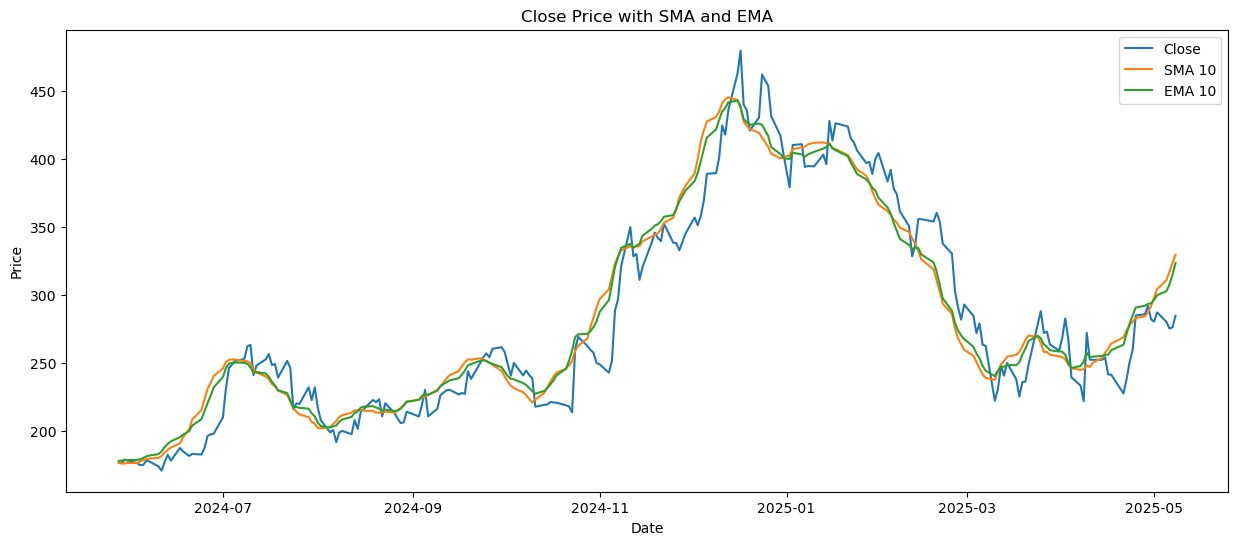

In [211]:
# SMA and EMA overlaid on Close
plt.figure(figsize=(15, 6))
plt.plot(df['Close'], label='Close')
plt.plot(df['SMA_10'], label='SMA 10')
plt.plot(df['EMA_10'], label='EMA 10')
plt.title('Close Price with SMA and EMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

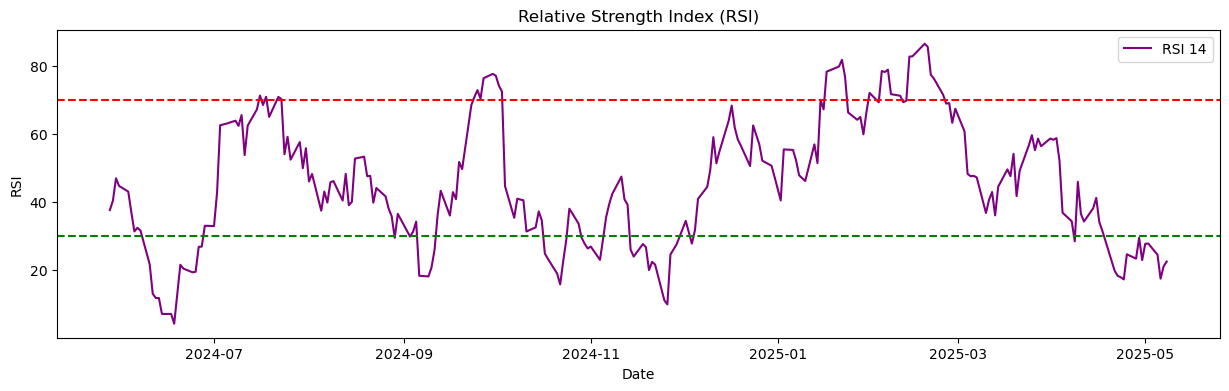

In [212]:
#  RSI Plot
plt.figure(figsize=(15, 4))
plt.plot(df['RSI_14'], color='purple', label='RSI 14')
plt.axhline(70, linestyle='--', color='red')
plt.axhline(30, linestyle='--', color='green')
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.show()

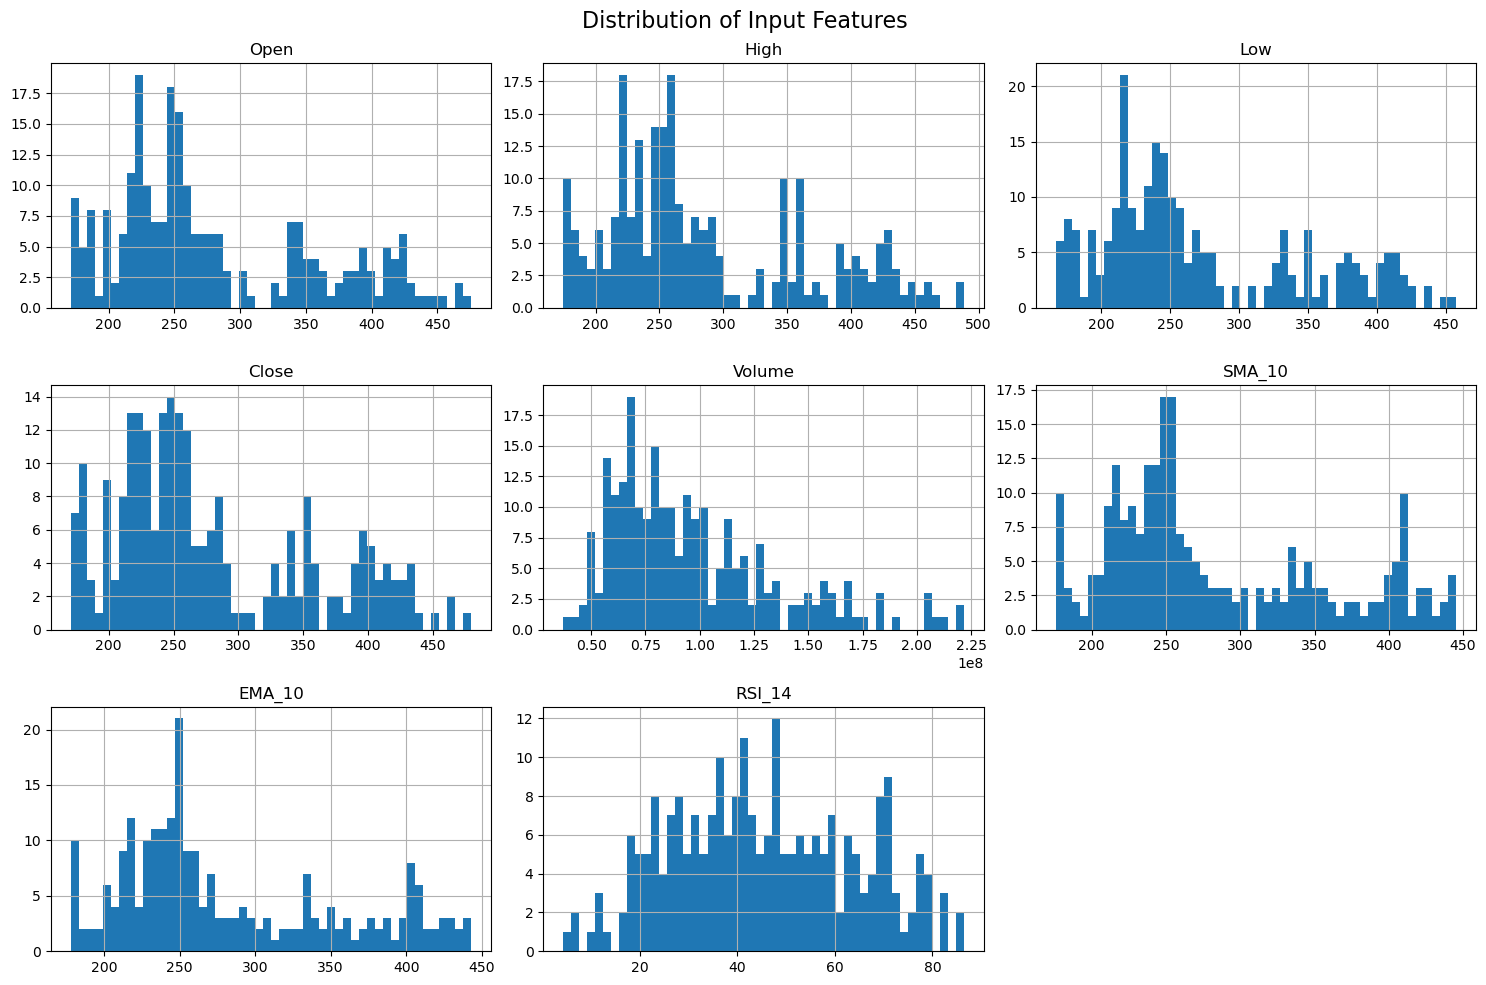

In [213]:
# Distribution of features
df[features].hist(bins=50, figsize=(15, 10))
plt.suptitle("Distribution of Input Features", fontsize=16)
plt.tight_layout()
plt.show()

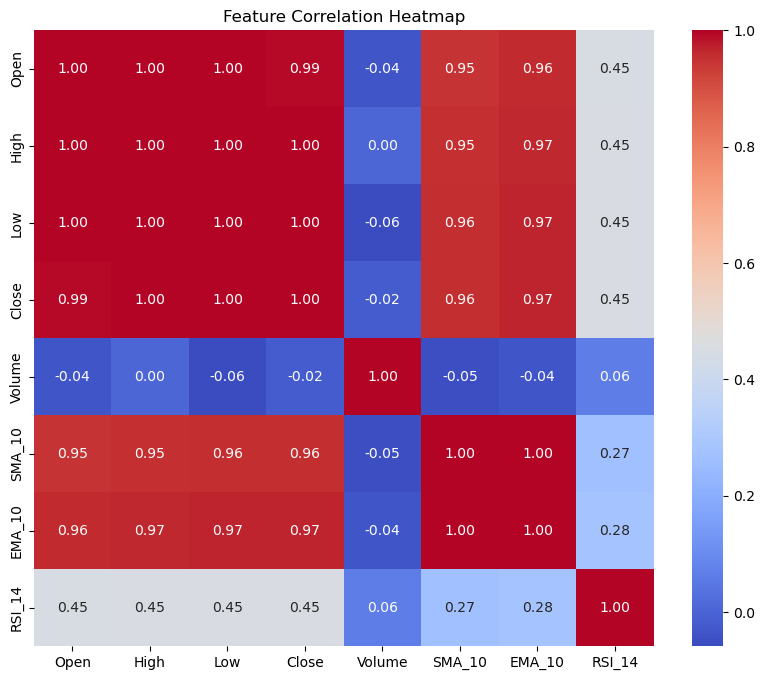

In [214]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df[features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

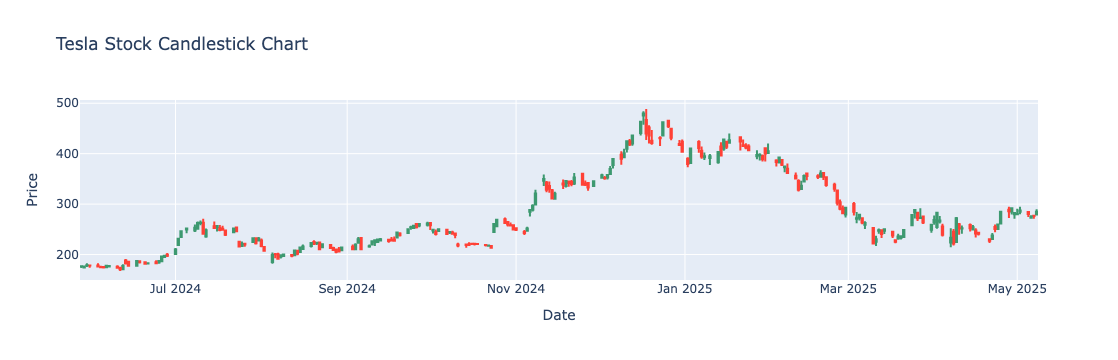

In [215]:
import plotly.graph_objs as go
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats

# Plotly Candlestick chart
candlestick = go.Figure(data=[go.Candlestick(x=df.index,
                                             open=df['Open'],
                                             high=df['High'],
                                             low=df['Low'],
                                             close=df['Close'])])
candlestick.update_layout(title='Tesla Stock Candlestick Chart',
                          xaxis_title='Date', yaxis_title='Price',
                          xaxis_rangeslider_visible=False)
candlestick.show()


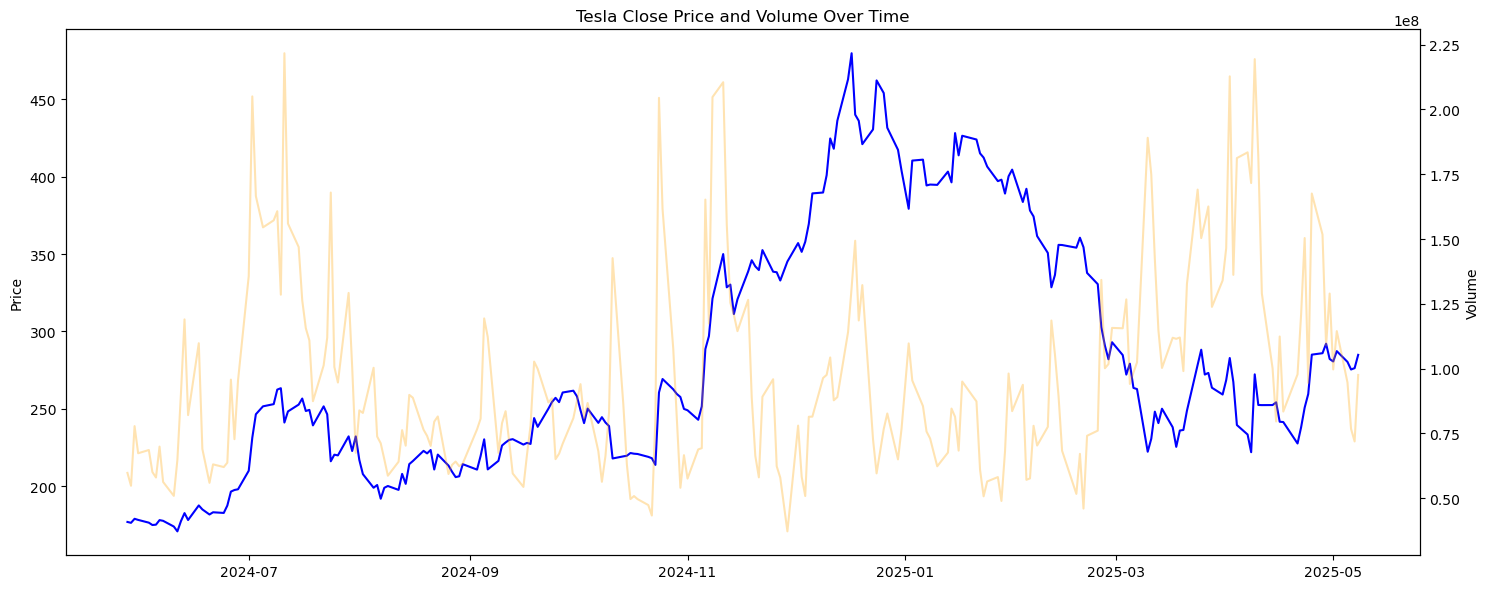

In [216]:
# Line plot for price and volume
fig, ax1 = plt.subplots(figsize=(15, 6))
ax1.plot(df.index, df['Close'], label='Close Price', color='blue')
ax1.set_ylabel('Price')
ax2 = ax1.twinx()
ax2.plot(df.index, df['Volume'], label='Volume', color='orange', alpha=0.3)
ax2.set_ylabel('Volume')
plt.title("Tesla Close Price and Volume Over Time")
fig.tight_layout()
plt.show()

In [217]:
# Outlier detection using Z-score
z_scores = np.abs(stats.zscore(df[features]))
outliers = (z_scores > 3)
outlier_rows = df[outliers.any(axis=1)]
print(f"Number of outlier rows: {len(outlier_rows)}")
if not outlier_rows.empty:
    display(outlier_rows)

Number of outlier rows: 3


,Open,High,Low,Close,Volume,SMA_10,EMA_10,RSI_14
Date,,,,,,,,
2025-04-09,224.69,274.69,223.88,272.20,219433406,248.250,257.509176,45.941320
2025-04-02,254.60,284.99,251.27,282.76,212787812,252.799,256.036850,58.759164
2024-07-11,263.30,271.00,239.65,241.03,221707297,244.927,242.876742,53.792753


In [218]:
# Normalize
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)


In [219]:
# Sequence creation
time_step = 60
x, y = [], []
for i in range(time_step, len(scaled_data)):
    x.append(scaled_data[i - time_step:i])
    y.append(scaled_data[i, features.index('Close')])

x, y = np.array(x), np.array(y)
train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [220]:
# Hypermodel for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int('units1', min_value=32, max_value=128, step=32),
        return_sequences=True,
        input_shape=(x_train.shape[1], x_train.shape[2])
    ))
    model.add(Dropout(hp.Float('dropout1', 0.1, 0.5, step=0.1)))
    model.add(LSTM(
        units=hp.Int('units2', min_value=32, max_value=128, step=32)
    ))
    model.add(Dropout(hp.Float('dropout2', 0.1, 0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(
        optimizer='adam',
        loss='mean_squared_error'
    )
    return model

In [221]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    overwrite=True,
    directory='tuner_dir',
    project_name='tesla_lstm_tune'
)

tuner.search(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)


Trial 5 Complete [00h 00m 03s]
val_loss: 0.0020362345967441797

Best val_loss So Far: 0.0019358820281922817
Total elapsed time: 00h 00m 15s


In [222]:
# Get best model's hyperparameters
best_hps = tuner.get_best_hyperparameters(1)[0]
print(f"Best Hyperparameters: units1={best_hps.get('units1')}, units2={best_hps.get('units2')}, dropout1={best_hps.get('dropout1')}, dropout2={best_hps.get('dropout2')}")

# Retrain best model
model = tuner.hypermodel.build(best_hps)
model.fit(x_train, y_train, epochs=20, batch_size=32, verbose=1)

Best Hyperparameters: units1=96, units2=128, dropout1=0.2, dropout2=0.2
Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.1506
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0250
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0207
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0145
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0098
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0122
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0095
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0066
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0075
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0049
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0065
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0054
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0055
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0054
Epoch 15/20
5/5 ━━━━━━━━━━━

In [223]:
# Predict and inverse transform
predictions = model.predict(x_test)
close_min = scaler.data_min_[features.index('Close')]
close_scale = scaler.data_range_[features.index('Close')]
predictions_rescaled = predictions * close_scale + close_min
y_test_rescaled = y_test.reshape(-1, 1) * close_scale + close_min


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


In [224]:
# Evaluate
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 12.48
MAE: 9.55


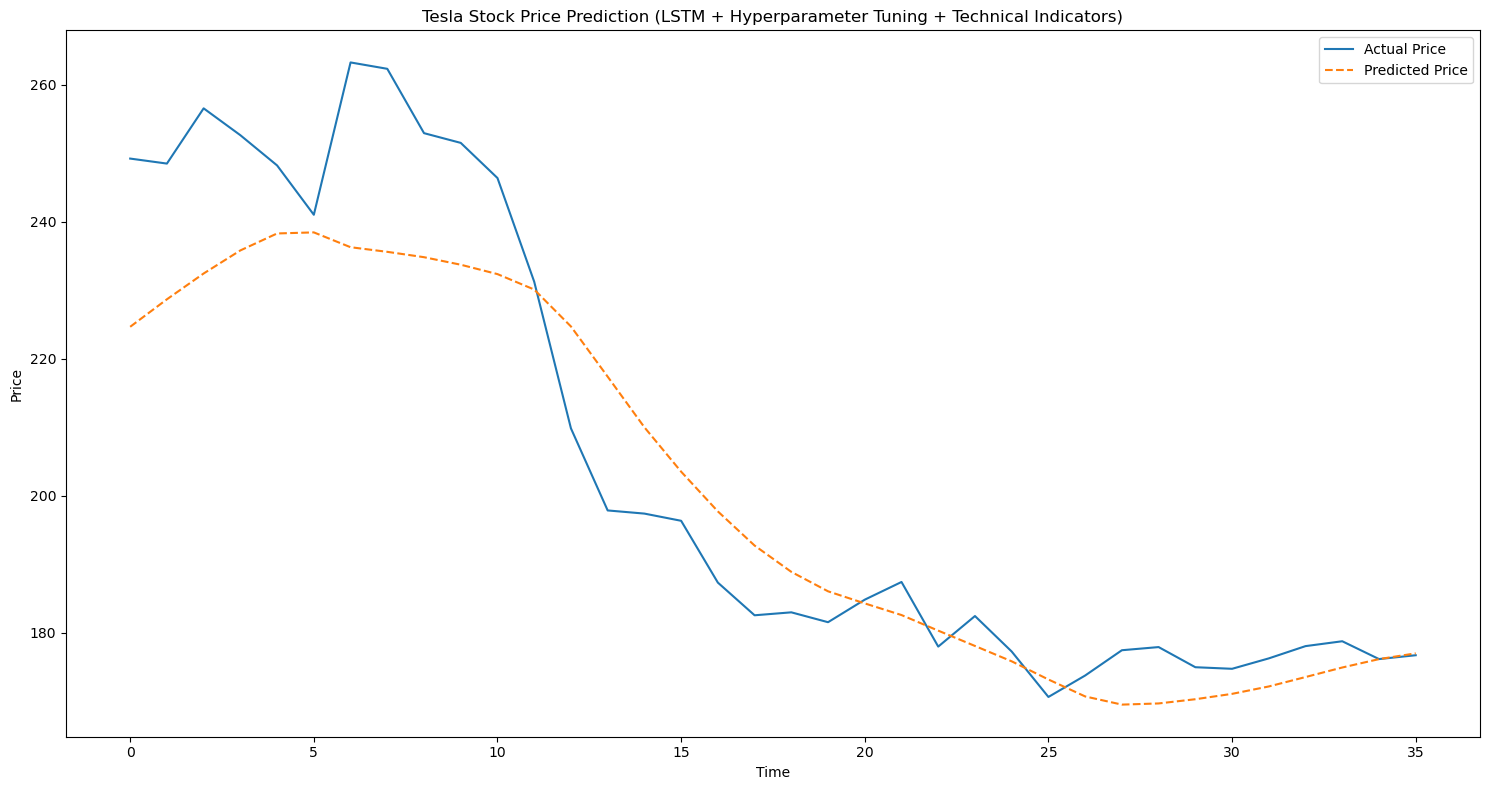

In [225]:
# Plot
plt.figure(figsize=(15, 8))
plt.plot(y_test_rescaled, label='Actual Price')
plt.plot(predictions_rescaled, label='Predicted Price', linestyle='--')
plt.title('Tesla Stock Price Prediction (LSTM + Hyperparameter Tuning + Technical Indicators)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()


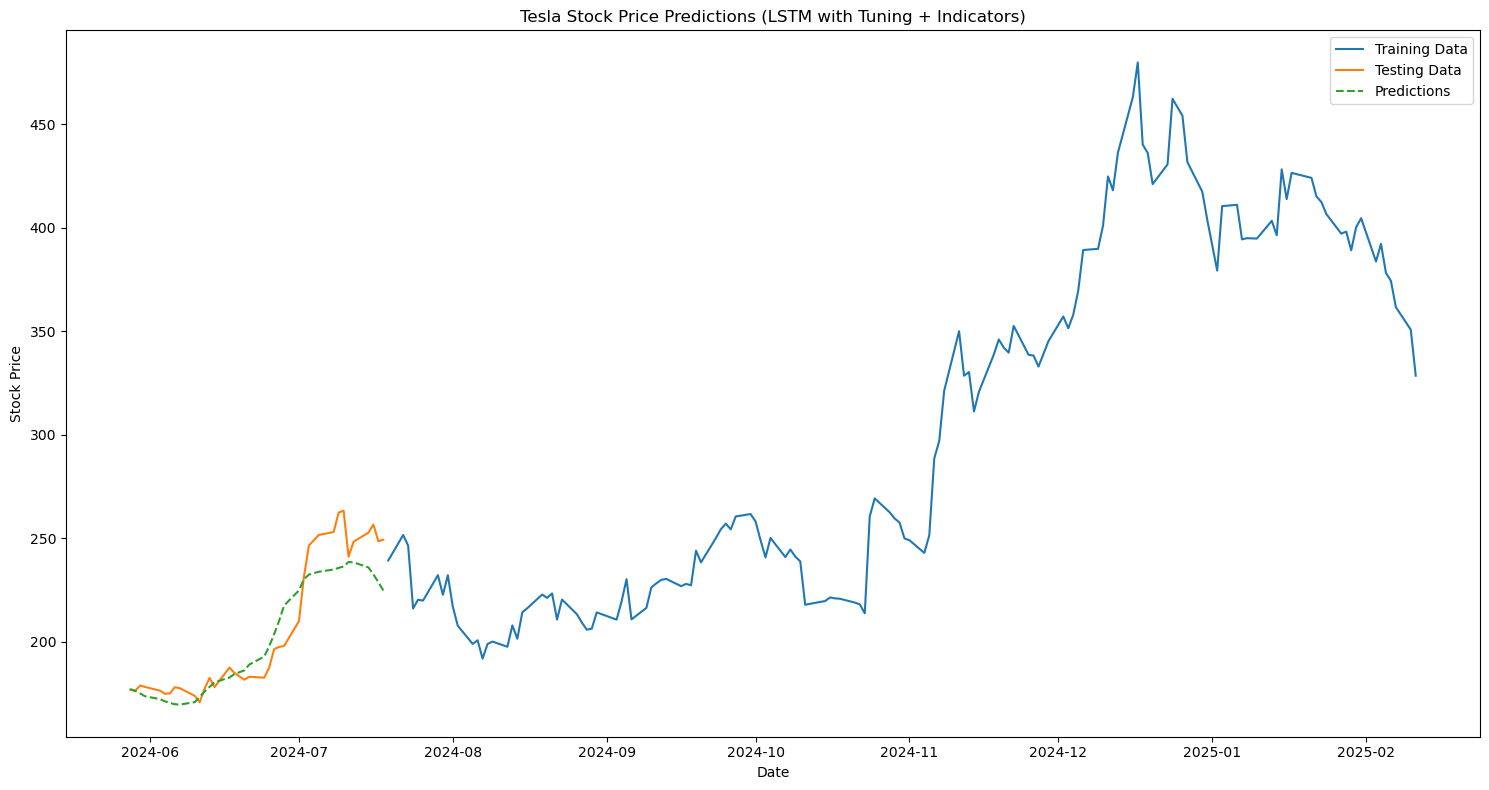

In [226]:
# Build DataFrames for plotting
train_dates = df.index[time_step:train_size + time_step]
test_dates = df.index[train_size + time_step:]

train_df = pd.DataFrame({'Date': train_dates, 'Adj Close': y_train.reshape(-1) * close_scale + close_min})
test_df = pd.DataFrame({'Date': test_dates, 'Adj Close': y_test_rescaled.flatten(), 'Predictions': predictions_rescaled.flatten()})

train_df.set_index('Date', inplace=True)
test_df.set_index('Date', inplace=True)

# Plot
plt.figure(figsize=(15, 8))
plt.plot(train_df['Adj Close'], label='Training Data')
plt.plot(test_df['Adj Close'], label='Testing Data')
plt.plot(test_df['Predictions'], label='Predictions', linestyle='--')
plt.title('Tesla Stock Price Predictions (LSTM with Tuning + Indicators)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.tight_layout()
plt.show()
